<center><font size="10"> 🔥Representation Learning using GAN🔥 </font></center>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mlb
import matplotlib.pyplot as plt
from tensorflow import keras

# Generative Adversarial Networks
#### Lets prepare the fashion MNIST dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#### First, we need to build the generator and the discriminator.

In [4]:
coding_size = 30

generator = keras.models.Sequential([
            keras.layers.Dense(100, activation = 'selu', input_shape = [coding_size]),
            keras.layers.Dense(150, activation = 'selu'),
            keras.layers.Dense(28 * 28, activation = "sigmoid"),
            keras.layers.Reshape([28, 28])
            ])

discriminator = keras.models.Sequential([
                keras.layers.Flatten(input_shape = [28, 28]),
                keras.layers.Dense(150, activation = 'selu'),
                keras.layers.Dense(100, activation = 'selu'),
                keras.layers.Dense(1, activation = 'sigmoid')
])

In [5]:
gan = keras.models.Sequential([generator, discriminator])

#### Now to train these models
#### The generator will only be trained through the GAN model, so we do not need to compile it at all.
#### The discriminator should not be trained during the second phase, so we make it non-trainable before compiling the GAN model

In [6]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [7]:
discriminator.trainable = False

In [8]:
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Inorder to train the model in 2 phases we have to use a custom function rather than a regular fit() method. So we first need to create a Dataset to iterate through the images

In [9]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

#### Code to plot GAN outputs

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

#### Lets make the training loop

In [17]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs = 50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:

            # phase-1 ===> training the discriminator
            noise =tf.random.normal(shape =[batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase-2 ===> training the generator
            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()


Epoch 1/10


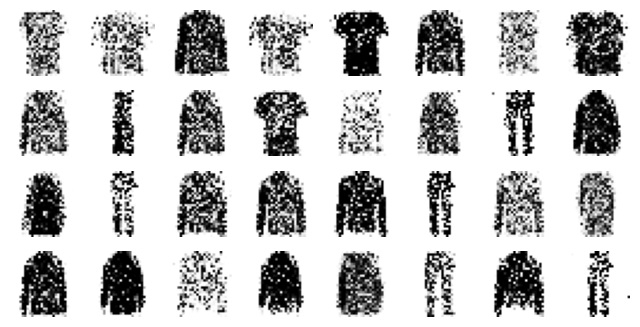

Epoch 2/10


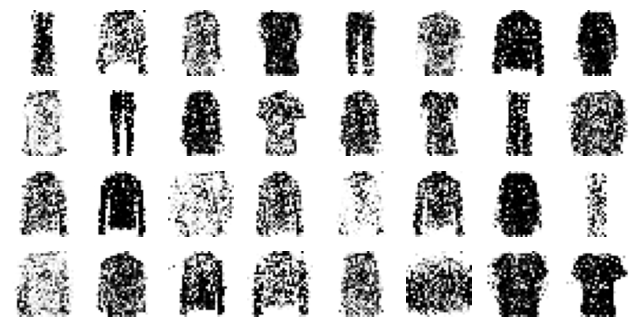

Epoch 3/10


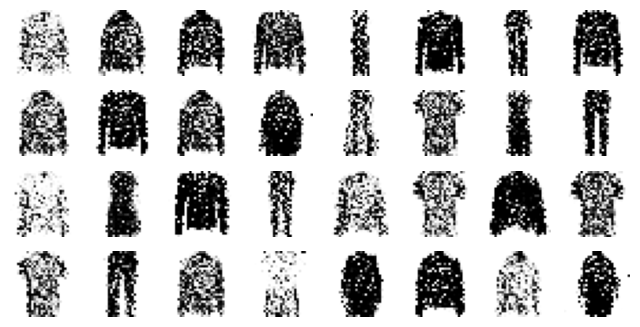

Epoch 4/10


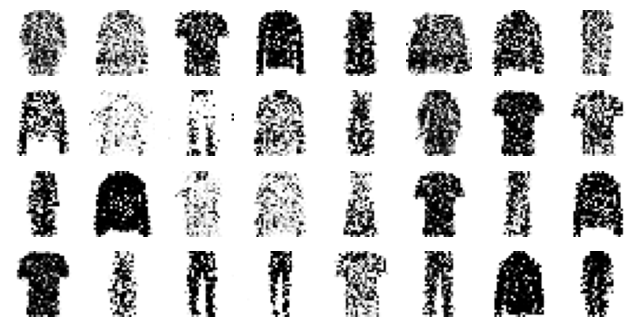

Epoch 5/10


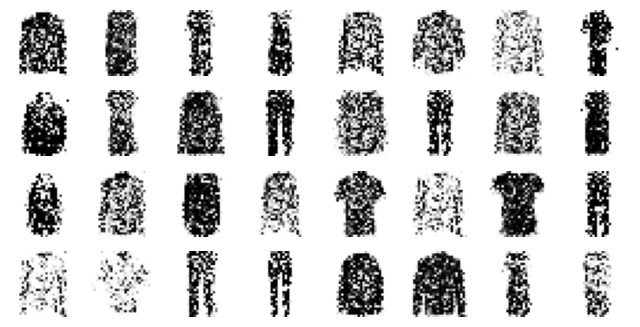

Epoch 6/10


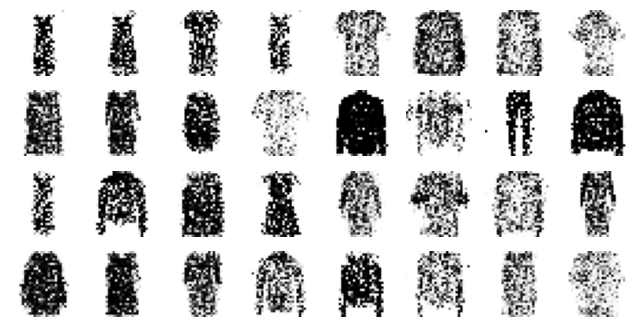

Epoch 7/10


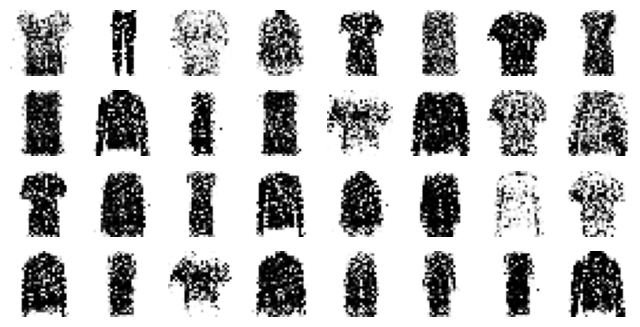

Epoch 8/10


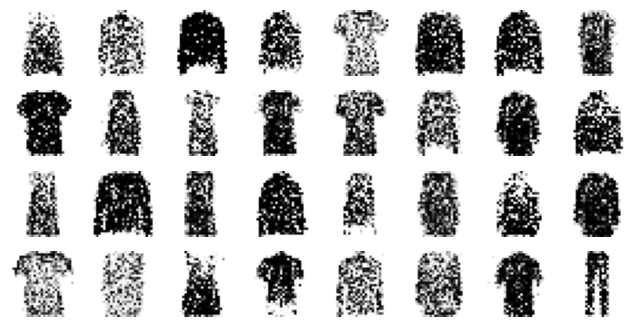

Epoch 9/10


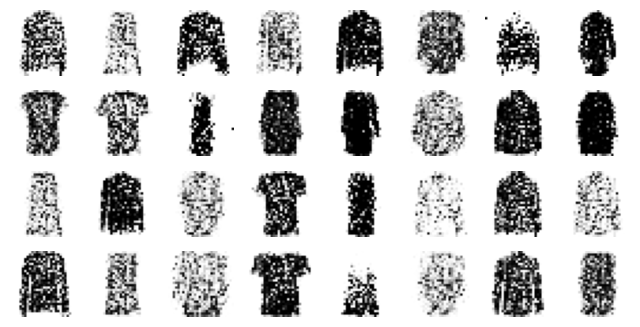

Epoch 10/10


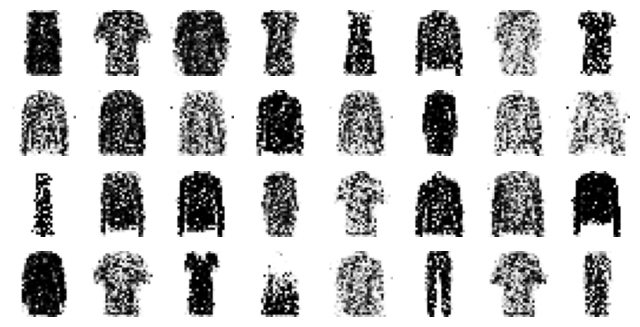

In [19]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=10)

# Deep Convolutional GAN (DCGAN)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

In [22]:
coding_size = 100

generator = keras.models.Sequential([
            keras.layers.Dense(7 * 7 * 128, input_shape=[coding_size]),
            keras.layers.Reshape([7, 7, 128]),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh"),
        ])


discriminator = keras.models.Sequential([
                keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
                keras.layers.Dropout(0.4),
                keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=keras.layers.LeakyReLU(0.2)),
                keras.layers.Dropout(0.4),
                keras.layers.Flatten(),
                keras.layers.Dense(1, activation="sigmoid")
            ])


gan = keras.models.Sequential([generator, discriminator])

In [23]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")


X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 


batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


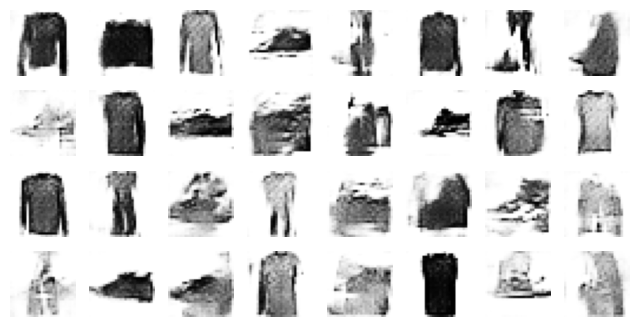

Epoch 2/10


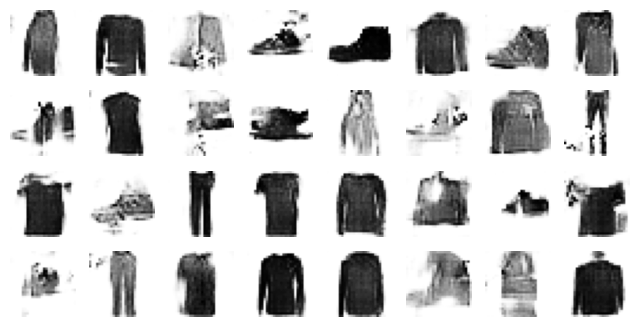

Epoch 3/10


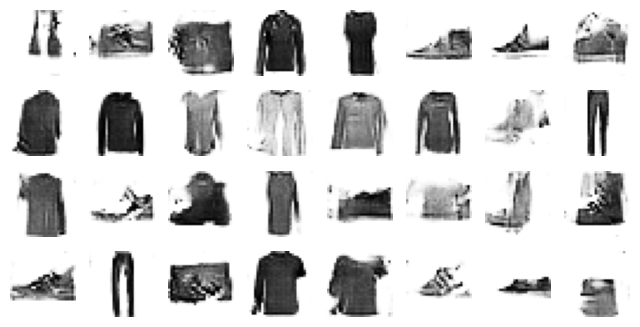

Epoch 4/10


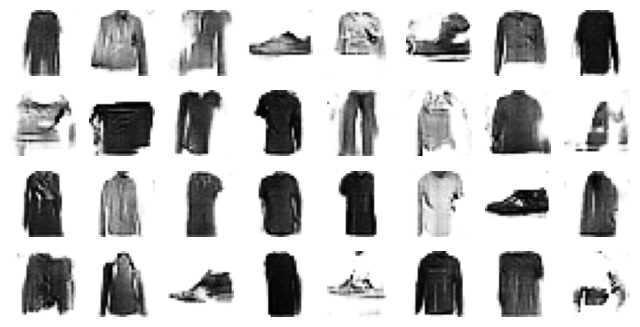

Epoch 5/10


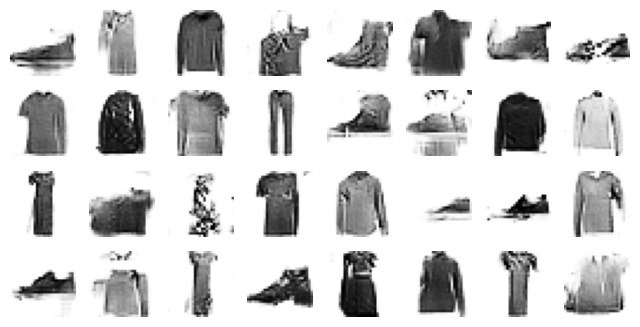

Epoch 6/10


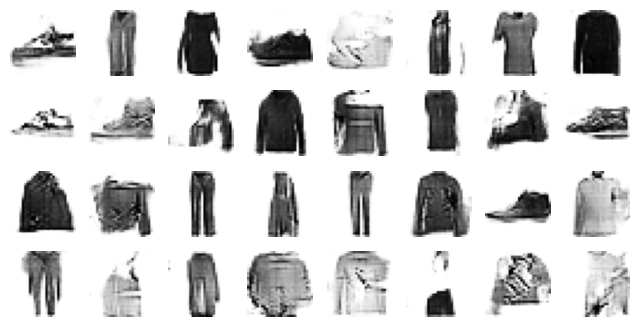

Epoch 7/10


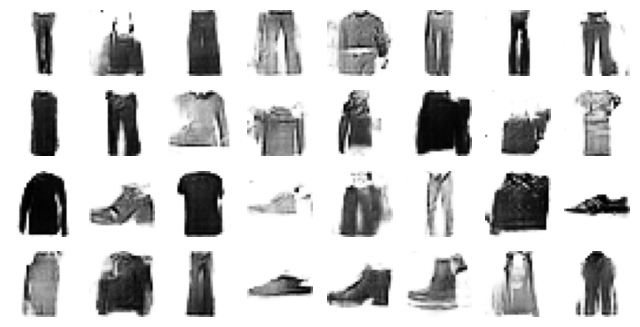

Epoch 8/10


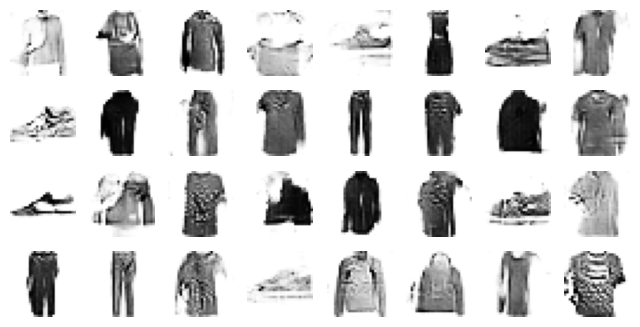

Epoch 9/10


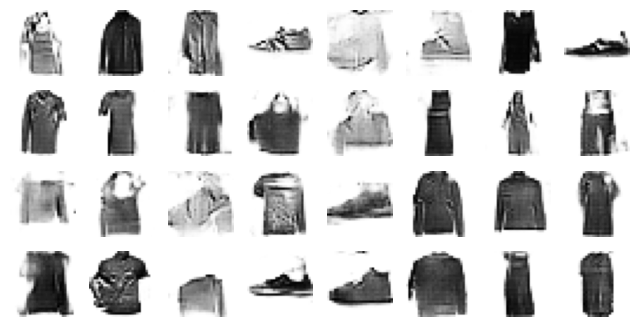

Epoch 10/10


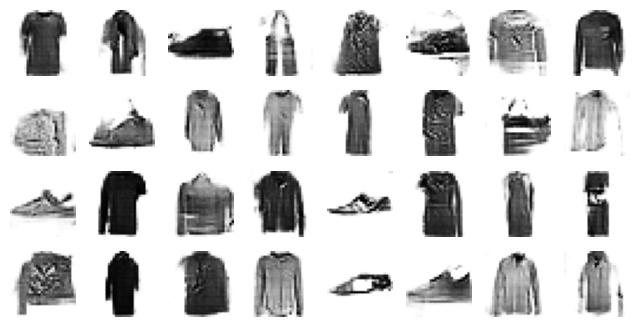

In [24]:
train_gan(gan, dataset, batch_size, coding_size, n_epochs=10)